In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F

In [2]:
with open('alice.txt', 'r', encoding='latin1') as f:
    data = f.read()
    
print("Extract: ", data[:50])
print("Length: ", len(data))

Extract:  ALICE was beginning to get very tired of sitting b
Length:  145178


In [3]:
chars = list(set(data))
indexer = {char: index for (index, char) in enumerate(chars)}

In [4]:
indexed_data = []
for c in data:
    indexed_data.append(indexer[c])
    
print("Indexed extract: ", indexed_data[:50])
print("Length: ", len(indexed_data))

Indexed extract:  [63, 32, 22, 37, 69, 2, 56, 19, 43, 2, 5, 15, 60, 35, 38, 38, 35, 38, 60, 2, 39, 24, 2, 60, 15, 39, 2, 12, 15, 8, 1, 2, 39, 35, 8, 15, 23, 2, 24, 62, 2, 43, 35, 39, 39, 35, 38, 60, 2, 5]
Length:  145178


In [5]:
def index2onehot(batch):
    
    batch_flatten = batch.flatten()
    onehot_flat = np.zeros((batch.shape[0] * batch.shape[1], len(indexer)))
    onehot_flat[range(len(batch_flatten)), batch_flatten] = 1
    onehot = onehot_flat.reshape((batch.shape[0], batch.shape[1], -1))
    
    return onehot

In [6]:
class LSTM(nn.Module):
    def __init__(self, char_length, hidden_size, n_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.lstm = nn.LSTM(char_length, hidden_size, n_layers, batch_first=True)
        self.output = nn.Linear(hidden_size, char_length)
        
    def forward(self, x, states):
        out, states = self.lstm(x, states)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.output(out)
        
        return out, states
    
    def init_states(self, batch_size):
        hidden = next(self.parameters()).data.new(self.n_layers, batch_size, self.hidden_size).zero_()
        cell = next(self.parameters()).data.new(self.n_layers, batch_size, self.hidden_size).zero_()
        states = (hidden, cell)
        
        return states 

In [7]:
n_seq = 100 ## Number of sequences per batch
seq_length =  50
n_batches = math.floor(len(indexed_data) / n_seq / seq_length)

total_length = n_seq * seq_length * n_batches
x = indexed_data[:total_length]
x = np.array(x).reshape((n_seq,-1))

In [8]:
model = LSTM(len(chars), 256, 2)
model

LSTM(
  (lstm): LSTM(70, 256, num_layers=2, batch_first=True)
  (output): Linear(in_features=256, out_features=70, bias=True)
)

In [9]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20

In [10]:
losses = []
for e in range(1, epochs+1):
    states = model.init_states(n_seq)
    batch_loss = []
    
    for b in range(0, x.shape[1], seq_length):
        x_batch = x[:,b:b+seq_length]
        
        if b == x.shape[1] - seq_length:
            y_batch = x[:,b+1:b+seq_length]
            y_batch = np.hstack((y_batch, indexer["."] * np.ones((y_batch.shape[0],1))))
        else:
            y_batch = x[:,b+1:b+seq_length+1]
        
        x_onehot = torch.Tensor(index2onehot(x_batch))
        y = torch.Tensor(y_batch).view(n_seq * seq_length)
        
        pred, states = model(x_onehot, states)
        loss = loss_function(pred, y.long())
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        batch_loss.append(loss.item())
        
    losses.append(np.mean(batch_loss))
    
    if e%1 == 0:
        print("epoch: ", e, "... Loss function: ", losses[-1])

epoch:  1 ... Loss function:  3.450181714419661
epoch:  2 ... Loss function:  3.167477410415123
epoch:  3 ... Loss function:  3.1628282892292945
epoch:  4 ... Loss function:  3.153110347945115
epoch:  5 ... Loss function:  3.0912397647726126
epoch:  6 ... Loss function:  2.880558466089183
epoch:  7 ... Loss function:  2.6486914240080734
epoch:  8 ... Loss function:  2.501002920084986
epoch:  9 ... Loss function:  2.4115809161087562
epoch:  10 ... Loss function:  2.338390827178955
epoch:  11 ... Loss function:  2.267730351152091
epoch:  12 ... Loss function:  2.206300275079135
epoch:  13 ... Loss function:  2.1507338819832635
epoch:  14 ... Loss function:  2.100295354580057
epoch:  15 ... Loss function:  2.0537281899616637
epoch:  16 ... Loss function:  2.0121903008428115
epoch:  17 ... Loss function:  1.9732320020938743
epoch:  18 ... Loss function:  1.9361771386245201
epoch:  19 ... Loss function:  1.9012044997050845
epoch:  20 ... Loss function:  1.8682923358062218


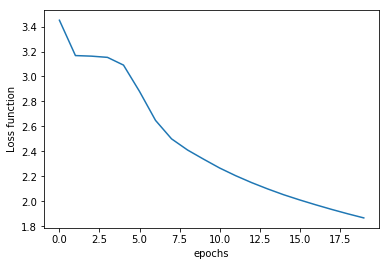

In [11]:
x_range = range(len(losses))
plt.plot(x_range, losses)
plt.xlabel("epochs")
plt.ylabel("Loss function")
plt.show()

In [13]:
starter = "So she was considering in her own mind "
states = None
for ch in starter:
    x = np.array([[indexer[ch]]])
    x = index2onehot(x)
    x = torch.Tensor(x)
    
    pred, states = model(x, states)

counter = 0
while starter[-1] != "." and counter < 50:
    counter += 1
    x = np.array([[indexer[starter[-1]]]])
    x = index2onehot(x)
    x = torch.Tensor(x)
    
    pred, states = model(x, states)
    pred = F.softmax(pred, dim=1)
    p, top = pred.topk(10)
    p = p.detach().numpy()[0]
    top = top.numpy()[0]
    index = np.random.choice(top, p=p/p.sum())
    
    starter += chars[index]
print(starter)

So she was considering in her own mind of would the cace to she tount ang to ges seokn.
